# Whole session raster

It crates a visualization in which the spikes rasters from all units in a recording are shown across the entire session. 
In addition to the spike rasters, it shows a couple basic kinematics metrics like speed and arena location.


In [1]:
# imports
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import medfilt

import matplotlib.patheffects as path_effects
from matplotlib.artist import Artist
from myterial import amber_darker, green_dark, grey_darker, blue_darker

sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from data.dbase.db_tables import Probe, Unit, Session, ValidatedSession, Recording, Tracking
from data.data_utils import convolve_with_gaussian
from myterial import amber_darker, green_dark, grey_darker, blue_darker

save_folder = Path(r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys")

# print all available recordings
print(*zip(*(Recording * Probe & "target='MOs'").fetch("name", "recording_probe_configuration")), sep="\n")




def outline(artist: Artist, lw: float = 1, color: str = "white"):
    artist.set_path_effects(
        [path_effects.withStroke(linewidth=lw, foreground=color,)]
    )

[06/04/22 10:15:35] DEBUG    DPL - Saving data and logs to logs                   ]8;id=846799;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py\core.py]8;;\:]8;id=33455;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py#118\118]8;;\

                    DEBUG    Saving log file to: logs\log.log                     ]8;id=143702;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py\core.py]8;;\:]8;id=355398;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py#119\119]8;;\

Connecting root@127.0.0.1:3306


[06/04/22 10:15:36] DEBUG    Connected to database: LOCOMOTION                 ]8;id=789498;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\data\dbase\__init__.py\__init__.py]8;;\:]8;id=645748;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\data\dbase\__init__.py#11\11]8;;\

('FC_220408_BAA1101192_hairpin', 'r72')
('FC_220409_BAA1101192_hairpin', 'r32')
('FC_220410_BAA1101192_hairpin', 'r64')
('FC_220411_BAA1101192_hairpin', 'r96')
('FC_220413_BAA1101192_hairpin', 'r96')
('FC_220414_BAA1101192_hairpin', 'r48')
('FC_220415_BAA1101192_hairpin', 'r96')
('FC_220432_BAA1101192_hairpin', 'r128')
('FC_220433_BAA1101192_hairpin', 'r128')
('FC_220434_BAA1101192_hairpin', 'r96')
('FC_220435_BAA1101192_hairpin', 'r64')


choose a recording and load the data

In [2]:
REC = "FC_220408_BAA1101192_hairpin"

metadata = pd.DataFrame(
    (Recording & f'name="{REC}"').fetch()
)

tracking = Tracking.get_session_tracking(REC)
print(tracking)

units = pd.DataFrame(Unit * Unit.Spikes * Probe.RecordingSite & f'name="{REC}"')
units = units.sort_values("brain_region", inplace=False).reset_index()


mouse_id                                                   BAA1101192
name                                     FC_220408_BAA1101192_hairpin
bpname                                                           body
orientation         [20.46860604547166, 2.2873084308201896, 16.283...
angular_velocity    [1228.1163627282995, -1090.8778568790883, 839....
speed               [6.340201506833432, 2.301073842891923, 0.98136...
acceleration        [6.340201506833432, -4.039127663941509, -1.319...
theta               [336.12072186875093, 9.083940881123056, 2.8749...
thetadot            [20167.243312125058, 1977.7931407423273, -372....
thetadotdot         [20167.243312125058, -18189.45017138273, -2350...
x                   [11.474095674820452, 11.417840250675154, 11.43...
y                   [4.503422038204072, 4.419646329903848, 4.44418...
bp_speed            [6.340201506833432, 2.301073842891923, 0.98136...
moving              [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
walking             

## make plot

c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator


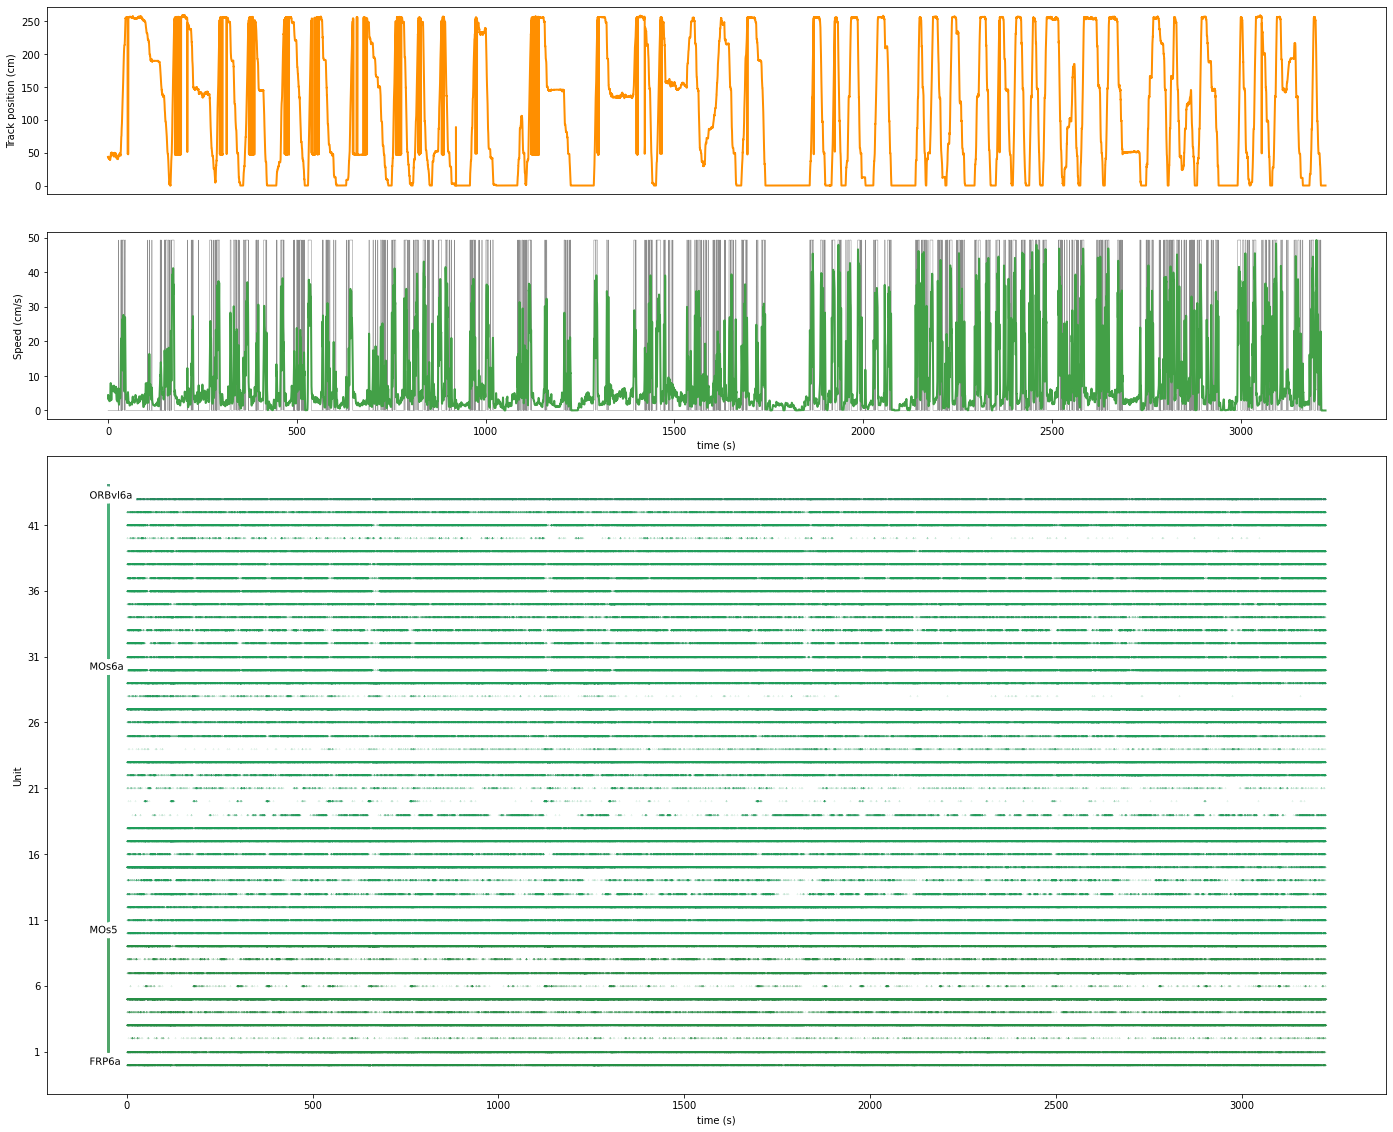

In [3]:
fig = plt.figure(figsize=(24, 20))

axes = fig.subplot_mosaic(
"""
    AAAAA
    BBBBB
    DDDDD
    DDDDD
    DDDDD
"""
)

tracking_time = np.arange(0,len(tracking.x+1)) / 60


# plot kinematics
axes["A"].plot(tracking_time, tracking.global_coord * 260, lw=2, color=amber_darker)
axes["A"].set(ylabel="Track position (cm)", xticks=[])

speed = convolve_with_gaussian(tracking.speed, 180)
_ =axes["B"].plot(tracking_time, medfilt(tracking.walking * np.max(speed), 31), lw=.5, alpha=.6, color=grey_darker)
_ =axes["B"].plot(tracking_time, speed, lw=2, color=green_dark)
_ =axes["B"].set(ylabel="Speed (cm/s)", xlabel="time (s)")


# plot spikes raster
nunits = len(units)
h = 1/nunits
# axes["D"].vlines(tracking_time[tracking.walking == 1], ymin=0, ymax=1, zorder=-1, color=grey_darker, lw=.5, alpha=.1)


regions = [ ]
last_added = 0
last_added_color = "black"
for (i, unit) in units.iterrows():
    spikes = unit.spikes_ms / 1000
    y = np.zeros_like(spikes) + (i * h)
    axes["D"].scatter(spikes, y, s=1, color=unit.color, alpha=0.1, marker=7)

    # add region as text
    if unit.brain_region not in regions:
        axes["D"].plot([-50, -50], [last_added, i * h], lw=3, color=last_added_color, alpha=0.8)
        last_added = i * h
        last_added_color = unit.color

        txt = axes["D"].text(-100, (i * h) , unit.brain_region, color="black", fontsize=10)
        outline(txt, lw=10, color="white")
        regions.append(unit.brain_region)
axes["D"].plot([-50, -50], [last_added, 1], lw=3, color=last_added_color, alpha=0.8)

_ = axes["D"].set(ylabel="Unit", xlabel="time (s)", yticklabels=np.arange(1, nunits + 1, step=5), yticks=np.arange(1, nunits + 1, step=5)/nunits)



# save figure as svg
fig.savefig(save_folder / f"{REC}_raster.png", dpi=100, bbox_inches="tight")